<h1 align="center"><font color='#4169E1'>QLearning Enabled Genetic Algorithm for the Flowshop Scheduling Problem</font></h1>

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random 
import pandas as pd
from functools import reduce

<h2><font color='#D23B68'>Lecture des instances de Taillard à partir d'un fichier txt</font></h2>

In [2]:
def get_data(filename, i,nb):
    nb = nb + 3
    with open(filename, 'r') as f:
        data = f.read()
    lines = data.split('\n')
    data = lines[i*nb:(i+1)*nb][3:]
    data = [x.split() for x in data]
    data = [[int(y) for y in x] for x in data]
    data = list(map(list, zip(*data)))

    nb_jobs = int(lines[i*nb:(i+1)*nb][1].split()[0])
    nb_machines = int(lines[i*nb:(i+1)*nb][1].split()[1])
    upper_bound = int(lines[i*nb:(i+1)*nb][1].split()[3])
    lower_bound = int(lines[i*nb:(i+1)*nb][1].split()[4])

    data = np.array(data).T
    return nb_jobs, nb_machines, upper_bound, lower_bound, data


<h2><font color='#D23B68'>Opérateurs et fonctions utils</font></h2>

In [3]:
def calc_makespan(solution, proccessing_time, number_of_jobs, number_of_machines):
    # list for the time passed until the finishing of the job
    cost = [0] * number_of_jobs
    # for each machine, total time passed will be updated
    for machine_no in range(0, number_of_machines):
        for slot in range(number_of_jobs):
            # time passed so far until the task starts to process
            cost_so_far = cost[slot]
            if slot > 0:
                cost_so_far = max(cost[slot - 1], cost[slot])
            cost[slot] = cost_so_far + proccessing_time[solution[slot]][machine_no]
    return cost[number_of_jobs - 1]


def initialize_population_Q(population_size, number_of_jobs):
    population = []
    population_actions =[]
    nb_opperation = 4
   
    i = 0
    while i < population_size:
        individual = list(np.random.permutation(number_of_jobs))
        if individual not in population:
            population.append(individual)
            population_actions.append(np.random.randint(nb_opperation))
            i += 1

    return population, population_actions

# Two-point crossover is that the set of jobs between 
# two randomly selected points is always inherited from one parent to the child, 
# and the other jobs are placed in the same manner as the one-point crossover. 

def crossover(solution,solution2):
    
    parent1= list(solution)
    parent2 = solution2
    
    length_of_parent = len(parent1)
    first_point = int(length_of_parent / 2 - length_of_parent / 4)
    second_point = int(length_of_parent - first_point)
    intersect = parent1[first_point:second_point]

    child = []
    index = 0
    for pos2 in range(len(parent2)):
        if first_point <= index < second_point:
            child.extend(intersect)
            index = second_point
        if parent2[pos2] not in intersect:
                child.append(parent2[pos2])
                index += 1

    return child

# apply mutation to an existing solution using swap move operator
def mutation(solution):
    # copy the solution
    mutated_solution = list(solution)
    solution_length = len(solution)
    # pick 2 positions to swap randomly
    swap_positions = list(np.random.permutation(np.arange(solution_length))[:2])
    first_job = solution[swap_positions[0]]
    second_job = solution[swap_positions[1]]
    mutated_solution[swap_positions[0]] = second_job
    mutated_solution[swap_positions[1]] = first_job
    return mutated_solution

def n_mutation(solution,n=10) : 
    n=2
    for i in range(n) : 
        solution = mutation(solution)
    return solution

# Selects parent by binary tournament method
def select_parent_Q(population,population_states, processing_time, number_of_jobs, number_of_machines,N):
    selected_parents = []
    # randomly choose how many parent pairs will be selected
    parent_count = N
    for k in range(parent_count):
        parent1,idx1 = binary_tournament_Q(number_of_jobs, number_of_machines, population, processing_time)
        # parent2,idx2 = binary_tournament_Q(number_of_jobs, number_of_machines, population, processing_time)
        # if parent1 != parent2 and (parent1, parent2) not in parent_pairs:
        if parent1 not in selected_parents:
            selected_parents.append((parent1,population_states[idx1]))
    return selected_parents #idx par rapport à la population

def rand_crossover(solution) : 
    solution = list(solution)
    length_of_parent = len(solution)
    parent2 = np.random.permutation(length_of_parent)
    first_point = int(length_of_parent / 2 - length_of_parent / 4)
    second_point = int(length_of_parent - first_point)
    intersect = solution[first_point:second_point]

    child = []
    index = 0
    for pos2 in range(len(parent2)):
        if first_point <= index < second_point:
            child.extend(intersect)
            index = second_point
        if parent2[pos2] not in intersect:
                child.append(parent2[pos2])
                index += 1

    return child


def binary_tournament_Q(number_of_jobs, number_of_machines, population, processing_time):
    parent = []
    # candidates = random.sample(population, 2)
    index1 = np.random.randint(len(population))
    index2 = np.random.randint(len(population))

    candidates = [population[index1], population[index2]]
    makespan1 = calc_makespan(candidates[0], processing_time, number_of_jobs, number_of_machines)
    makespan2 = calc_makespan(candidates[1], processing_time, number_of_jobs, number_of_machines)
    if makespan1 < makespan2:
        parent = candidates[0]
        rang_parent = index1
    else:
        parent = candidates[1]
        rang_parent = index2
    
    return parent, rang_parent

def update_population_Q(population,population_states, children,processing_time,no_of_jobs,no_of_machines):
    costed_population = []
    for i in range(len(population)):
        ind_makespan = (calc_makespan(population[i], processing_time, no_of_jobs, no_of_machines), population[i],population_states[i])
        costed_population.append(ind_makespan)
    costed_population.sort(key=lambda x: x[0], reverse=True)

    costed_children = []
    for individual in children:
        ind_makespan = (calc_makespan(individual[0], processing_time, no_of_jobs, no_of_machines), individual[0], individual[1])
        costed_children.append(ind_makespan)
    costed_children.sort(key=lambda x: x[0])
    N = len(population)
    N_inter = len(children)

    
    for i in range(N) : 
        # if i <N - N_inter:
        #     population[i] = costed_population[i][1]
        #     population_states[i] = costed_population[i][2]
        # else: 
        if i< N_inter:
            population[i] = costed_children[i][1]
            population_states[i] = costed_children[i][2]
        else: 
            population[i] = costed_population[i-N_inter][1]
            population_states[i] = costed_population[i-N_inter][2]
    return population, population_states

In [4]:
def operator(oper,Cmax,solution,withcmax=True) : 
    
    solution = oper(solution)
    return solution
    

def operator_AG(operator_name,initial_sol) :
    """
    Desc : 
        Run the operator_name on the given problem instance C
    
    Args   :
        operator_name : string
        C : 2D numpy array
        initial_sol : list
        
    Return : 
        solution : list
        makespan : float
    """

    solution = []
    operators = ["o1","o2","o3","o4"]
    
    assert operator_name in operators, "Invalide Operator Name"
    
    if operator_name == "o1" :
        solution = mutation(initial_sol)
        
    elif operator_name == "o2" :
        solution = rand_crossover(initial_sol)
        
    elif operator_name == "o3" :
        solution = n_mutation(initial_sol)

    return solution


def operator_AG4(operator_name,initial_sol,sol2) :
    
    solution=crossover(initial_sol,solution2=sol2)
    
    return solution

def QL_update(Q_tab,current_state,action,fun,old_fun,ep=.5, lr=.1, gamma=0.99, exploration_proba=1, min_exploration_proba=.01, exploration_decreasing_decay=0.001):
        
        next_state = action
        reward = 1 if fun - old_fun > 0 else 0  # Calculate the reward based on the improvement of the solution

            # Update Q-table using Q-learning formula
        Q_tab[current_state, action] = (1 - lr) * Q_tab[current_state, action] + lr * (reward + gamma * max(Q_tab[next_state, :]))
        return Q_tab


<h2><font color='#D23B68'>Classe Flowshop</font></h2>

In [5]:
class Flowshop(object):

    def __init__(self, data, nb_machines, nb_jobs, max_time=100):
        """
            data : A 2D array of processing times on machines.
            nb_machines : Number of machines for the given problem must be the number of rows of first param.
            nb_jobs  : Number of jobs for the given problem, must be equal to the number of columns of the data param. 
        """
        self.nb_machines = nb_machines
        self.nb_jobs = nb_jobs
        self.data = data
        self.Ql_table = []

        if data is None:
            self.data = self.generate_random(max_time)
            
    def generate_random(self, max_time):
        """
        Generates matrix of random processing times.
        Returns:
            ndarray of random processing times of shape (nb_machines, nb_jobs)
        """
        return np.random.randint(
            1,
            max_time,
            size=( self.nb_machines, self.nb_jobs )
        )
    
    def _get_makespan(self, seq, data):
        # Initialize a matrix 'c' of size nb_machines x len(seq) to hold the start and end times for each job on each machine
        c = np.zeros((self.nb_machines, len(seq)), dtype=object)
        
        # Fill in the first row of 'c' with the start and end times for the first job on each machine
        c[0][0] = (0, data[0][seq[0]])
        for m_id in range(1, self.nb_machines):
            s_t = c[m_id-1][0][1] # Get the end time of the last job on the previous machine
            e_t = s_t + data[m_id][0] # Calculate the end time of the first job on the current machine
            c[m_id][0] = (s_t, e_t) # Set the start and end times for the first job on the current machine
        
        # Fill in the rest of 'c' with the start and end times for each job on each machine
        if len(seq) > 1:
            for i, job_id in enumerate(seq[1::]):
                # Fill in the start and end times for the job on the first machine
                s_t = c[0][i][1] # Get the end time of the previous job on the first machine
                e_t = s_t + data[0][job_id] # Calculate the end time of the current job on the first machine
                c[0][i+1] = (s_t, e_t) # Set the start and end times for the current job on the first machine
                
                # Fill in the start and end times for the job on the rest of the machines
                for m_id in range(1, self.nb_machines):
                    s_t = max(c[m_id][i][1], c[m_id-1][i+1][1]) # Get the maximum of the end time of the previous job on the current machine and the end time of the current job on the previous machine
                    e_t = s_t + data[m_id][job_id] # Calculate the end time of the current job on the current machine
                    c[m_id][i+1] = (s_t, e_t) # Set the start and end times for the current job on the current machine
                    
        # Return the ending time of the last job on the last machine as the makespan
        return c[self.nb_machines-1][-1][1]


    def QL_offline(self, solution_initiale, n_episodes=1000,Q_tab=None, ep=.5, lr=.1, gamma=0.99, exploration_proba=1, min_exploration_proba=.01, exploration_decreasing_decay=0.001):
        #inits 
        operations = ["o1", "o2", "o3", "o4"]  # List of available heuristics
        initial_sol = list(solution_initiale)
        current_state = np.random.randint(len(operations))
        Q_table = np.zeros((len(operations), len(operations)))  # Initialize Q-table with zeros
        
        #processingtime list
        processing_time = []
        for i in range(self.nb_jobs):
            temp = []
            for j in range(self.nb_machines):
                temp.append(self.data[j][i])
            processing_time.append(temp)
        data = processing_time

        # add population !! 
        # Initialize population

        
        state = current_state
        sol = operator_AG(operations[current_state], initial_sol)  # Apply heuristic to generate initial solution
        fun = calc_makespan(initial_sol, processing_time, self.nb_jobs, self.nb_machines)

        total_episode_reward = 0

        # Q-learning loop
        for e in range(n_episodes):
            if np.random.uniform(0, 1) < exploration_proba:
                action = np.random.randint(len(operations))  # Randomly choose an action
            else:
                action = np.argmax(Q_table[current_state, :])  # Choose action with the highest Q-value

            old_fun = fun
            next_state = action
            
            if action == 3 : 
                sol2 = np.random.permutation(len(initial_sol))
                sol= operator_AG4(operations[action], initial_sol=sol,sol2=sol2)  # Apply selected heuristic to generate a new solution
                fun = calc_makespan(sol, processing_time, self.nb_jobs, self.nb_machines)
            else:
                sol = operator_AG(operations[action], initial_sol=sol)  # Apply selected heuristic to generate a new solution
                fun = calc_makespan(sol, processing_time, self.nb_jobs, self.nb_machines)
            
            reward = 1 if fun - old_fun > 0 else 0  # Calculate the reward based on the improvement of the solution
            total_episode_reward = total_episode_reward + reward

            # Update Q-table using Q-learning formula
            Q_table[current_state, action] = (1 - lr) * Q_table[current_state, action] + lr * (reward + gamma * max(Q_table[next_state, :]))

            # Update exploration probability
            exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e))

            current_state = action  # Update the current state

        print(Q_table)  # Print the learned Q-table
        self.Ql_table = Q_table
        return Q_table
    
    
    
    def QL_update(Q_tab,current_state,action,fun,old_fun,ep=.5, lr=.1, gamma=0.99, exploration_proba=1, min_exploration_proba=.01, exploration_decreasing_decay=0.001):
        
        next_state = action
        reward = 1 if fun - old_fun > 0 else 0  # Calculate the reward based on the improvement of the solution

            # Update Q-table using Q-learning formula
        Q_tab[current_state, action] = (1 - lr) * Q_tab[current_state, action] + lr * (reward + gamma * max(Q_tab[next_state, :]))
        return Q_tab

    def AGQ_offline(self,Q_table,N,N_inter,maxiter=100, ep =.5) :
        #inits: 
        no_of_machines,no_of_jobs = self.nb_machines,self.nb_jobs
        operations = ["o1", "o2", "o3", "o4"]  # List of available heuristics
        #processingtime list
        processing_time = []
        for i in range(self.nb_jobs):
            temp = []
            for j in range(self.nb_machines):
                temp.append(self.data[j][i])
            processing_time.append(temp)
        data = processing_time    
            
        default_timer = time.time
        s = default_timer.__call__()

        # Initialize population
        population,population_states = initialize_population_Q(N, no_of_jobs)

        # Genetic Algorithm loop
        for i in range(maxiter):
            # 1.Select parents
            parent_list = select_parent_Q(population,population_states, data, no_of_jobs, no_of_machines,N_inter) #list of set 
            childs = []
        
            # 2.generate pooling stage using Q_table
            for i in range(N_inter) : #parcourir parent_list
                individu = parent_list[i][0]
                state = parent_list[i][1]
                if np.random.uniform(0, 1) < ep:
                    action = np.argmax(Q_table[state, :])  # Choose the action with the highest Q-value
              
                else:
                    action = np.random.randint(len(operations))  # Randomly choose an action
                
                # action = np.argmax(Q_table[state, :])  # Choose the action with the highest Q-value
                if action == 3 : 
                    indiv2 = parent_list[np.random.randint(N_inter)][0]
                    child = operator_AG4(operations[action],initial_sol=individu,sol2=indiv2)
                    fun = calc_makespan(child,self.data.T,self.nb_jobs, self.nb_machines)
                
                else: 
                    child = operator_AG(operations[action],initial_sol=individu )  # Apply selected heuristic to generate a new solution

                    fun = calc_makespan(child,self.data.T,self.nb_jobs, self.nb_machines)
                

                childs.append((child,action))
            
            # 3.Update population

            if len(childs) > 0:
                population , population_states = update_population_Q(population,population_states, childs, data, no_of_jobs, no_of_machines)
        
        e = default_timer.__call__()
        exec_time = e-s
        
        costed_population = []
        for individual in population:
            ind_makespan = (calc_makespan(individual, self.data.T, no_of_jobs, no_of_machines), individual)
            costed_population.append(ind_makespan)
        costed_population.sort(key=lambda x: x[0])

        best_sol = costed_population[0][1]
        best_makespan = costed_population[0][0]

        
       
        return best_sol,best_makespan,exec_time
    

    def AGQ_online(self,Q_table,N,N_inter,maxiter=100, ep =.5) :
        #inits: 
        no_of_machines,no_of_jobs = self.nb_machines,self.nb_jobs
        operations = ["o1", "o2", "o3", "o4"]  # List of available heuristics
        #processingtime list
        processing_time = []
        for i in range(self.nb_jobs):
            temp = []
            for j in range(self.nb_machines):
                temp.append(self.data[j][i])
            processing_time.append(temp)
        data = processing_time    
            
        default_timer = time.time
        s = default_timer.__call__()

        # Initialize population
        population,population_states = initialize_population_Q(N, no_of_jobs)

        # Genetic Algorithm loop
        for i in range(maxiter):
            # 1.Select parents
            parent_list = select_parent_Q(population,population_states, data, no_of_jobs, no_of_machines,N_inter) #list of set 
            childs = []
        
            # 2.generate pooling stage using Q_table
            for i in range(N_inter) : #parcourir parent_list
                individu = parent_list[i][0]
                state = parent_list[i][1]
                old_fun = calc_makespan(individu,self.data.T,self.nb_jobs, self.nb_machines)
                if np.random.uniform(0, 1) < ep:
                    action = np.argmax(Q_table[state, :])  # Choose the action with the highest Q-value
              
                else:
                    action = np.random.randint(len(operations))  # Randomly choose an action
                
                # action = np.argmax(Q_table[state, :])  # Choose the action with the highest Q-value
                if action == 3 : 
                    indiv2 = parent_list[np.random.randint(N_inter)][0]
                    child = operator_AG4(operations[action],initial_sol=individu,sol2=indiv2)
                    fun = calc_makespan(child,self.data.T,self.nb_jobs, self.nb_machines)
                
                else: 
                    child = operator_AG(operations[action],initial_sol=individu )  # Apply selected heuristic to generate a new solution
                    fun = calc_makespan(child,self.data.T,self.nb_jobs, self.nb_machines)
                
                Q_table = QL_update(Q_table,state,action,fun,old_fun)
                childs.append((child,action))
            
            # 3.Update population

            if len(childs) > 0:
                population , population_states = update_population_Q(population,population_states, childs, data, no_of_jobs, no_of_machines)
        
        e = default_timer.__call__()
        exec_time = e-s
        
        costed_population = []
        for individual in population:
            ind_makespan = (calc_makespan(individual, self.data.T, no_of_jobs, no_of_machines), individual)
            costed_population.append(ind_makespan)
        costed_population.sort(key=lambda x: x[0])

        best_sol = costed_population[0][1]
        best_makespan = costed_population[0][0] 

        self.Ql_table = Q_table
     
        return best_sol,best_makespan,exec_time



<h1><font color='#4169E1'>Tests de performance</font></h1>

<h2><font color='#D23B68'>Instances de taillard : 20 jobs et 5 machines</font></h2>

In [ ]:
n = 10
width = 0.35
ind = np.arange(n)
fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []
deviation_list = []

for i in range(10):
    n_jobs, n_machines, ub,lb, processing_times = get_data("./taillard_instances/tai20_5.txt", i,5)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence, cmax, runtime = fs.AGQ_online(Q_table,N=300,N_inter=50,maxiter=100)
    Q_table = fs.Ql_table
    # runtime_list.append(runtime)
    print(f"Instance {i+1}  : Cmax = {cmax} | UB = {ub} | Deviation = {(cmax - ub)/ub} | Runtime = {runtime} s")
    cmax_bar = ax.bar(ind[i] - width/2, cmax, width, color='pink')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='purple')
    deviation_list.append((cmax - ub)/ub)
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)
    

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()

<h2><font color='#D23B68'>Instances de taillard : 20 jobs et 10 machines</font></h2>

Instance 1  : Cmax = 3844 | UB = 3025 | Deviation = 0.2707438016528926 | Runtime = 8.840786933898926
Instance 2  : Cmax = 3644 | UB = 2892 | Deviation = 0.2600276625172891 | Runtime = 8.935647010803223
Instance 3  : Cmax = 3700 | UB = 2864 | Deviation = 0.2918994413407821 | Runtime = 10.071266651153564
Instance 4  : Cmax = 3750 | UB = 3064 | Deviation = 0.22389033942558748 | Runtime = 9.324353218078613
Instance 5  : Cmax = 3741 | UB = 2986 | Deviation = 0.25284661754855997 | Runtime = 9.501164197921753
Instance 6  : Cmax = 3791 | UB = 3006 | Deviation = 0.261144377910845 | Runtime = 9.02260136604309
Instance 7  : Cmax = 3663 | UB = 3107 | Deviation = 0.1789507563566141 | Runtime = 9.009275197982788
Instance 8  : Cmax = 3607 | UB = 3039 | Deviation = 0.18690358670615334 | Runtime = 9.344656229019165
Instance 9  : Cmax = 3776 | UB = 2902 | Deviation = 0.30117160578911095 | Runtime = 9.404649257659912
Instance 10  : Cmax = 3883 | UB = 3091 | Deviation = 0.25622775800711745 | Runtime = 9.8

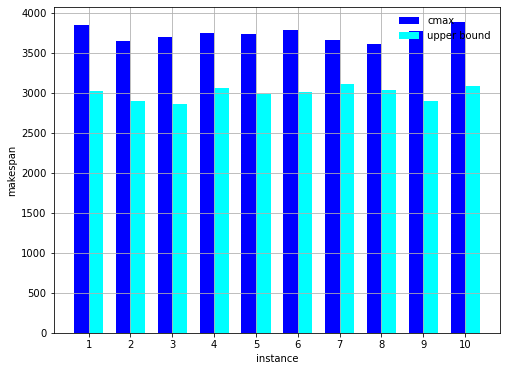

In [82]:
n = 10
width = 0.35
ind = np.arange(n)
fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []
runtime_list = []
deviation_list = []

for i in range(10):
    n_jobs, n_machines, ub,lb, processing_times = get_data("./taillard_instances/tai50_10.txt", i,10)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence, cmax, runtime = fs.AGQ_online(Q_table,N=300,N_inter=50,maxiter=100)
    Q_table = fs.Ql_table
    print(f"Instance {i+1}  : Cmax = {cmax} | UB = {ub} | Deviation = {(cmax - ub)/ub} | Runtime = {runtime}")
    runtime_list.append(runtime)
    deviation_list.append((cmax - ub)/ub)
    cmax_bar = ax.bar(ind[i] - width/2, cmax, width, color='blue')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='cyan')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()


<h1><font color='#4169E1'>Tests comparatifs</font></h1>

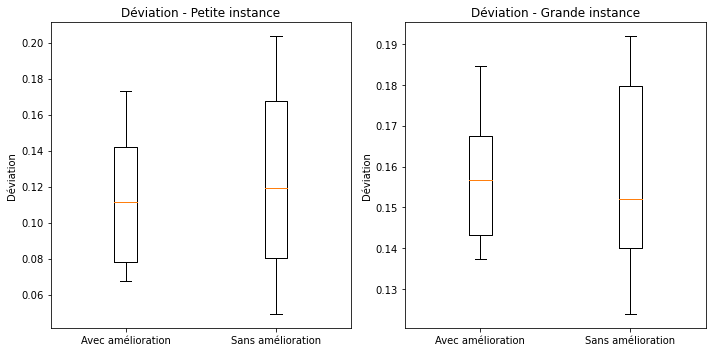

In [93]:
# Données fictives pour l'exemple
classes = ['petite instance (10,5)' ,'grande instance (50,10)'] 
critere = ['Runtime', 'Déviation']


#petite
runtime_sans = [3.515554189682007,
 3.485182523727417,
 3.5992536544799805,
 3.3119027614593506,
 3.23500919342041,
 3.2507715225219727,
 3.118755578994751,
 3.1061935424804688,
 3.2738630771636963,
 3.3505847454071045]

deviation_sans = [0.07668231611893583,
 0.07505518763796909,
 0.1461609620721554,
 0.1585460170146945,
 0.0825242718446602,
 0.11129707112970712,
 0.06779661016949153,
 0.12935323383084577,
 0.11138211382113822,
 0.17328519855595667]

runtime_avec =[2.1097395420074463,
 2.1051840782165527,
 2.149658441543579,
 1.988389015197754,
 1.985696792602539,
 1.9897680282592773,
 1.9945836067199707,
 1.979388952255249,
 1.970371961593628,
 1.9574253559112549]

deviation_avec = [0.04929577464788732,
 0.05003679175864607,
 0.20351526364477335,
 0.12064965197215777,
 0.10275080906148867,
 0.1497907949790795,
 0.07263922518159806,
 0.17330016583747926,
 0.17804878048780487,
 0.11732851985559567]

#grande instance
runtime_avec2 = [8.840786933898926,
 8.935647010803223,
 10.071266651153564,
 9.324353218078613,
 9.501164197921753,
 9.02260136604309,
 9.009275197982788,
 9.344656229019165,
 9.404649257659912,
 9.869380712509155]

deviation_avec2 = [0.1807438016528926,
 0.1800276625172891,
 0.1918994413407821,
 0.12389033942558748,
 0.15284661754855997,
 0.151144377910845,
 0.1789507563566141,
 0.12690358670615334,
 0.15117160578911095,
 0.13622775800711745]

diviation_sans2 = [0.14677685950413222,
 0.17496542185338865,
 0.18470670391061453,
 0.16481723237597912,
 0.13730743469524448,
 0.15934797072521623,
 0.15416800772449307,
 0.14215202369200394,
 0.16850447966919366,
 0.1397605952766095]

runtime_sans2= [14.539640426635742,
 17.248456478118896,
 14.976422548294067,
 14.030268430709839,
 13.88132929801941,
 15.760391235351562,
 14.73675799369812,
 14.819639921188354,
 14.54051923751831,
 15.137766361236572]


import matplotlib.pyplot as plt

# Données pour la petite instance
plt.figure(figsize=(10, 5))

# Boxplot Déviation
plt.subplot(1, 2, 1)
plt.boxplot([deviation_sans, deviation_avec], labels=[ 'Avec amélioration','Sans amélioration'])
# plt.xlabel('Amélioration')
plt.ylabel('Déviation')
plt.title('Déviation - Petite instance')

# Données pour la grande instance
plt.subplot(1, 2, 2)
plt.boxplot([diviation_sans2, deviation_avec2], labels=[ 'Avec amélioration','Sans amélioration',])
# plt.xlabel('Amélioration')
plt.ylabel('Déviation')
plt.title('Déviation - Grande instance')

plt.tight_layout()
plt.show()




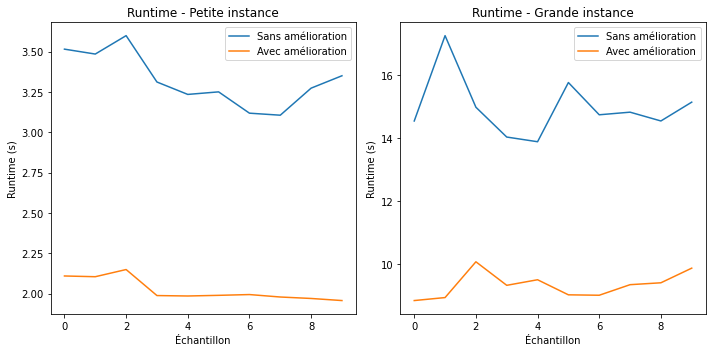

In [95]:
import matplotlib.pyplot as plt

# Données pour la petite instance
plt.figure(figsize=(10, 5))

# Plot du runtime pour la petite instance
plt.subplot(1, 2, 1)
plt.plot(runtime_sans, label='Sans amélioration')
plt.plot(runtime_avec, label='Avec amélioration')
plt.xlabel('Échantillon')
plt.ylabel('Runtime (s)')
plt.title('Runtime - Petite instance')
plt.legend()

# Données pour la grande instance
plt.subplot(1, 2, 2)
plt.plot(runtime_sans2, label='Sans amélioration')
plt.plot(runtime_avec2, label='Avec amélioration')
plt.xlabel('Échantillon')
plt.ylabel('Runtime (s)')
plt.title('Runtime - Grande instance')
plt.legend()

plt.tight_layout()
plt.show()


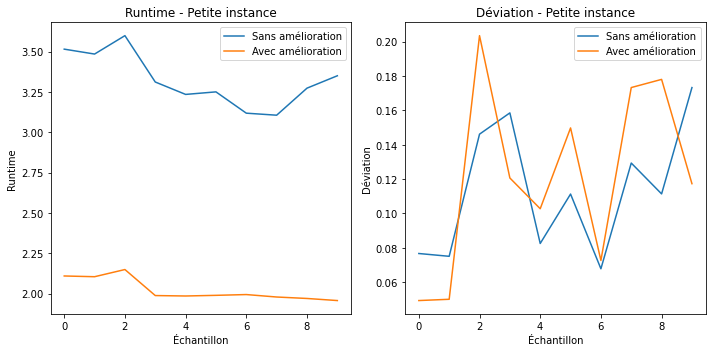

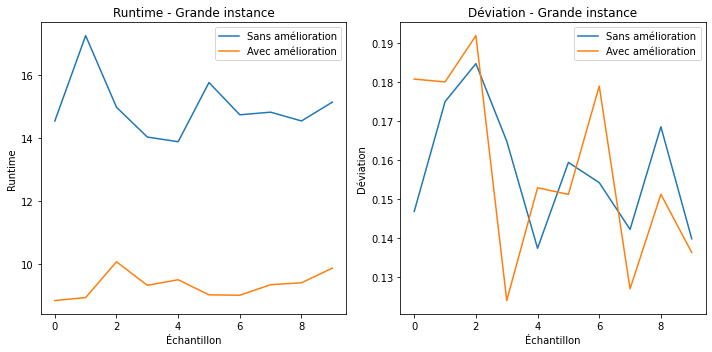

In [103]:
import matplotlib.pyplot as plt

# Données pour la petite instance
plt.figure(figsize=(10, 5))

# Graphique Runtime
plt.subplot(1, 2, 1)
plt.plot(runtime_sans, label='Sans amélioration')
plt.plot(runtime_avec, label='Avec amélioration')
plt.xlabel('Échantillon')
plt.ylabel('Runtime')
plt.title('Runtime - Petite instance')
plt.legend()

# Graphique Déviation
plt.subplot(1, 2, 2)
plt.plot(deviation_sans, label='Sans amélioration')
plt.plot(deviation_avec, label='Avec amélioration')
plt.xlabel('Échantillon')
plt.ylabel('Déviation')
plt.title('Déviation - Petite instance')
plt.legend()

plt.tight_layout()
plt.show()


# Données pour la grande instance
plt.figure(figsize=(10, 5))

# Graphique Runtime
plt.subplot(1, 2, 1)
plt.plot(runtime_sans2, label='Sans amélioration')
plt.plot(runtime_avec2, label='Avec amélioration')
plt.xlabel('Échantillon')
plt.ylabel('Runtime')
plt.title('Runtime - Grande instance')
plt.legend()

# Graphique Déviation
plt.subplot(1, 2, 2)
plt.plot(diviation_sans2, label='Sans amélioration')
plt.plot(deviation_avec2, label='Avec amélioration')
plt.xlabel('Échantillon')
plt.ylabel('Déviation')
plt.title('Déviation - Grande instance')
plt.legend()

plt.tight_layout()
plt.show()


Instance 1  : Cmax = 6775 | UB = 5770 | Deviation = 0.17417677642980936 | Runtime = 23.58542513847351
Instance 2  : Cmax = 6326 | UB = 5349 | Deviation = 0.18265096279678444 | Runtime = 23.390833854675293
Instance 3  : Cmax = 6499 | UB = 5677 | Deviation = 0.14479478597850978 | Runtime = 24.365342378616333
Instance 4  : Cmax = 6894 | UB = 5791 | Deviation = 0.19046796753583145 | Runtime = 26.862529039382935
Instance 5  : Cmax = 6306 | UB = 5468 | Deviation = 0.15325530358449158 | Runtime = 24.90886926651001
Instance 6  : Cmax = 6356 | UB = 5303 | Deviation = 0.19856684895342258 | Runtime = 25.508020877838135
Instance 7  : Cmax = 6466 | UB = 5599 | Deviation = 0.1548490801928916 | Runtime = 23.85512614250183
Instance 8  : Cmax = 6502 | UB = 5623 | Deviation = 0.15632224791036814 | Runtime = 24.209094047546387
Instance 9  : Cmax = 6782 | UB = 5875 | Deviation = 0.15438297872340426 | Runtime = 23.901398420333862
Instance 10  : Cmax = 6696 | UB = 5845 | Deviation = 0.1455945252352438 | Run

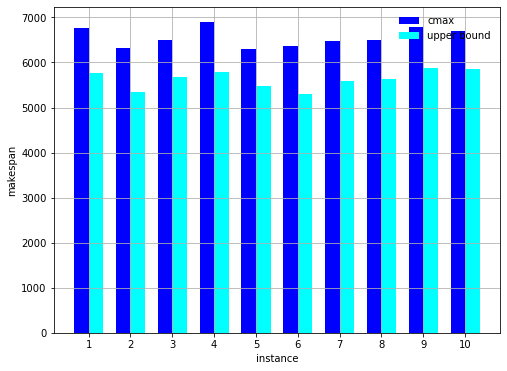

In [105]:
n = 10
width = 0.35
ind = np.arange(n)
fig, ax = plt.subplots(figsize=(8,6))

cmax_bars = []
ub_bars = []
runtime_list = []
deviation_list = []

for i in range(10):
    n_jobs, n_machines, ub,lb, processing_times = get_data("./taillard_instances/tai100_10.txt", i,10)
    fs = Flowshop(processing_times,n_machines,n_jobs)
    sequence, cmax, runtime = fs.AGQ_online(Q_table,N=300,N_inter=50,maxiter=100)
    Q_table = fs.Ql_table
    print(f"Instance {i+1}  : Cmax = {cmax} | UB = {ub} | Deviation = {(cmax - ub)/ub} | Runtime = {runtime}")
    runtime_list.append(runtime)
    deviation_list.append((cmax - ub)/ub)
    cmax_bar = ax.bar(ind[i] - width/2, cmax, width, color='blue')
    ub_bar = ax.bar(ind[i] + width/2, ub, width, color='cyan')
    
    cmax_bars.append(cmax_bar)
    ub_bars.append(ub_bar)

ax.set_xticks(ind)
ax.set_xticklabels([str(i+1) for i in range(n)])
ax.set_xlabel('instance')
ax.set_ylabel('makespan')
ax.legend([cmax_bars[0], ub_bars[0]], ['cmax', 'upper bound'], loc='upper right', frameon=False)
ax.grid(True)
plt.show()